# Backtesting

This notebook generates plots for the backtesting. It requires that the script `run_backtesting.sh` has been run prior to execution.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

In [3]:
# configure logging
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
# This line can be used to modify logging as required later in the notebook
#logging.getLogger().setLevel(logging.INFO)

In [4]:
# set matplotlib params
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [5]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 2161248 samples


In [6]:
# inspect the loaded data
print(columns.keys())
print('---')
for k in columns.keys():
    print(k, columns[k][0:2])

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])
---
lineage ['B.1', 'B.1']
virus_name ['hCoV-19/Australia/NT12/2020', 'hCoV-19/Australia/NT13/2020']
accession_id ['EPI_ISL_426900', 'EPI_ISL_426901']
collection_date ['2020-03-25', '2020-03-25']
location ['Oceania / Australia / Northern Territory', 'Oceania / Australia / Northern Territory']
add_location ['', '']
day [115, 115]


## Load trained models

In [7]:
fits = torch.load("results/mutrans.backtesting.pt", map_location="cpu")

In [8]:
# print info on available models and what the keys are
if False:
    for key in fits:
        print(key)
    first_key = list(fits.keys())[0]
    fits[first_key].keys()

In [9]:
# Print the shape of the weekly strains in each fit
if False:
    for fit in fits.values():
        print(fit["weekly_strains_shape"])

Scale `coef` by 1/100 in all results.

In [10]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix="", verbose=True):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                if verbose:
                    print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}", verbose=verbose)
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits, verbose=False)

# Forecasting

In [11]:
import importlib
from pyrocov import mutrans_helpers

In [12]:
# customize logging
if False:
    logging.getLogger().setLevel(logging.ERROR)

## Day 542: Last available

In [13]:
if False:
    logging.getLogger().setLevel(logging.INFO)

Max days of model: 542


    16154 Generating output tensor
    16156 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


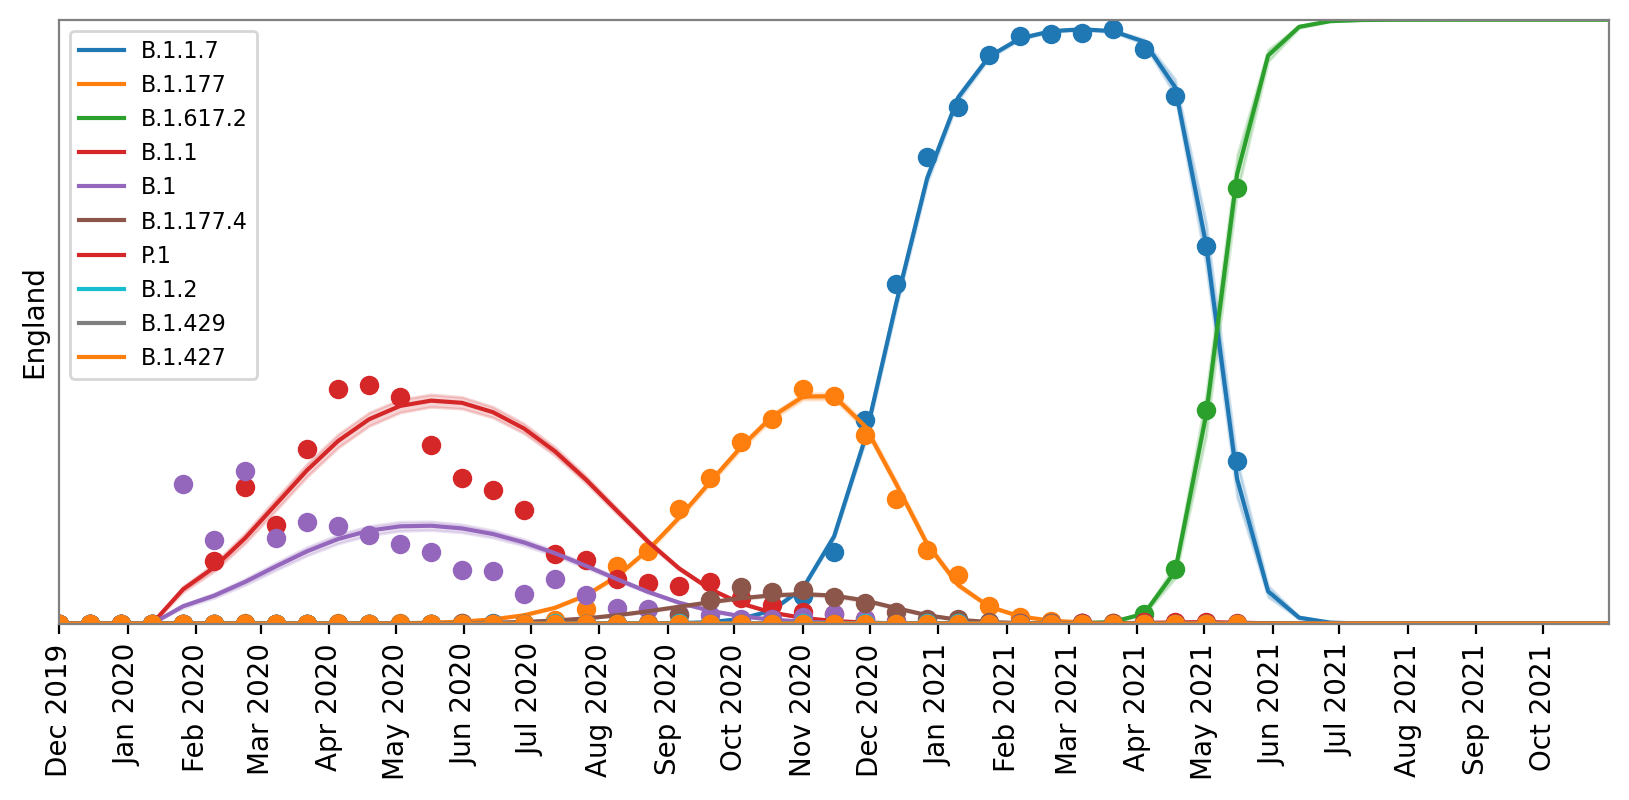

In [14]:
importlib.reload(mutrans_helpers)

i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    filename="paper/forecasts/forecast_day_542.png"
)

## Day 346:  B.1.1.7 in UK

    25854 Generating output tensor
    25855 --- Processing query 0


Max days of model: 346
sel_forecast shape torch.Size([37, 1281])
sel_forecast_lb shape torch.Size([37, 1281])


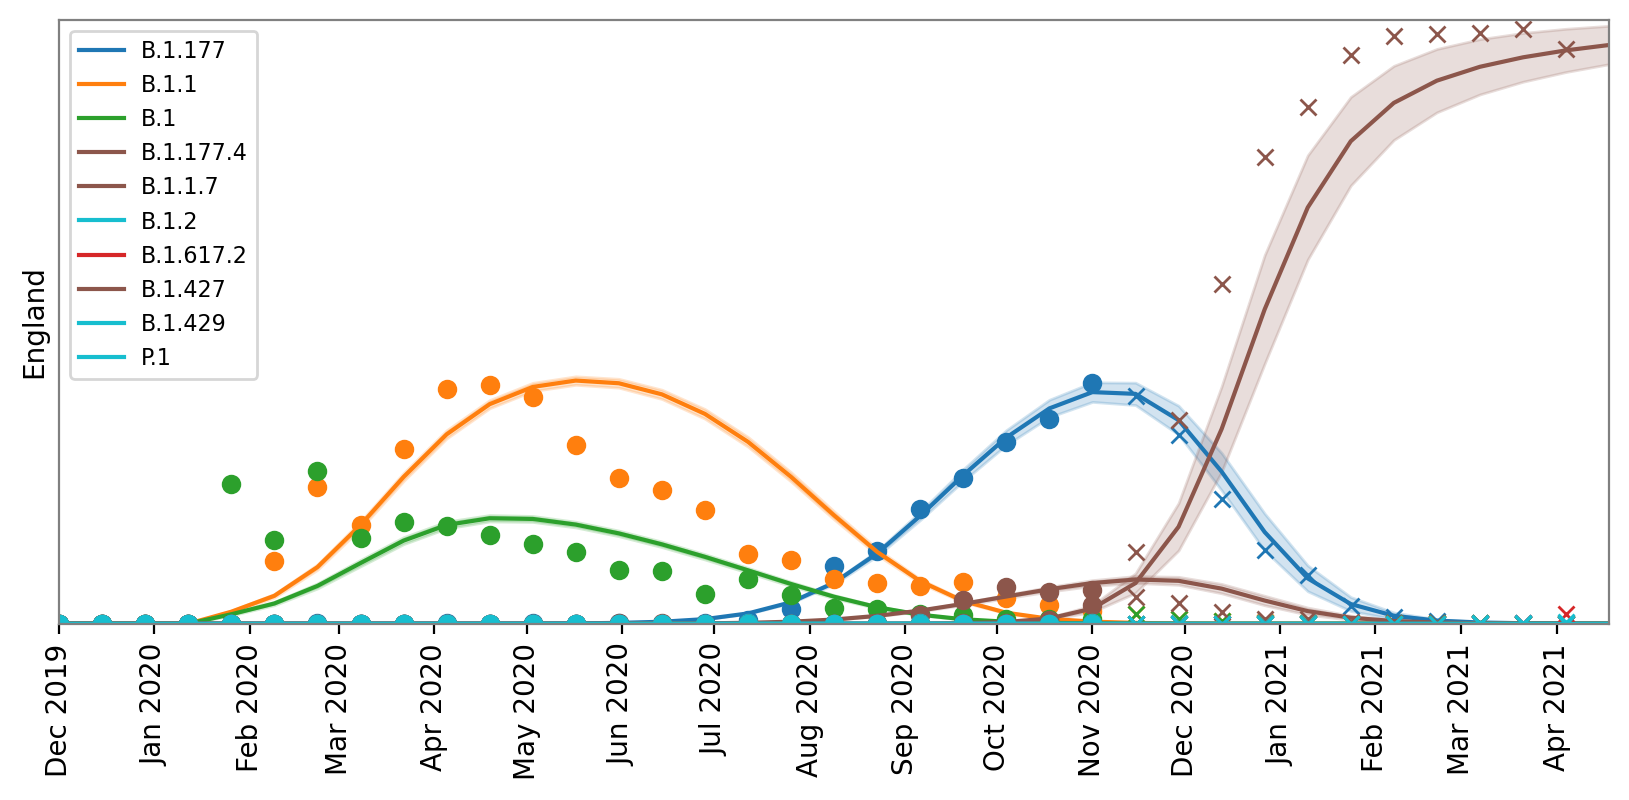

In [15]:
importlib.reload(mutrans_helpers)

i = 14
key, fit_d346 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d346, 
    strains_to_show=strains_from_manuscript_figure,queries=['England'],
    future_fit=latest_fit,
    filename="paper/forecasts/forecast_day_346.png"
)

In [16]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

fit_eval_d346 = mutrans_helpers.evaluate_fit_forecast(fit_d346, latest_fit)

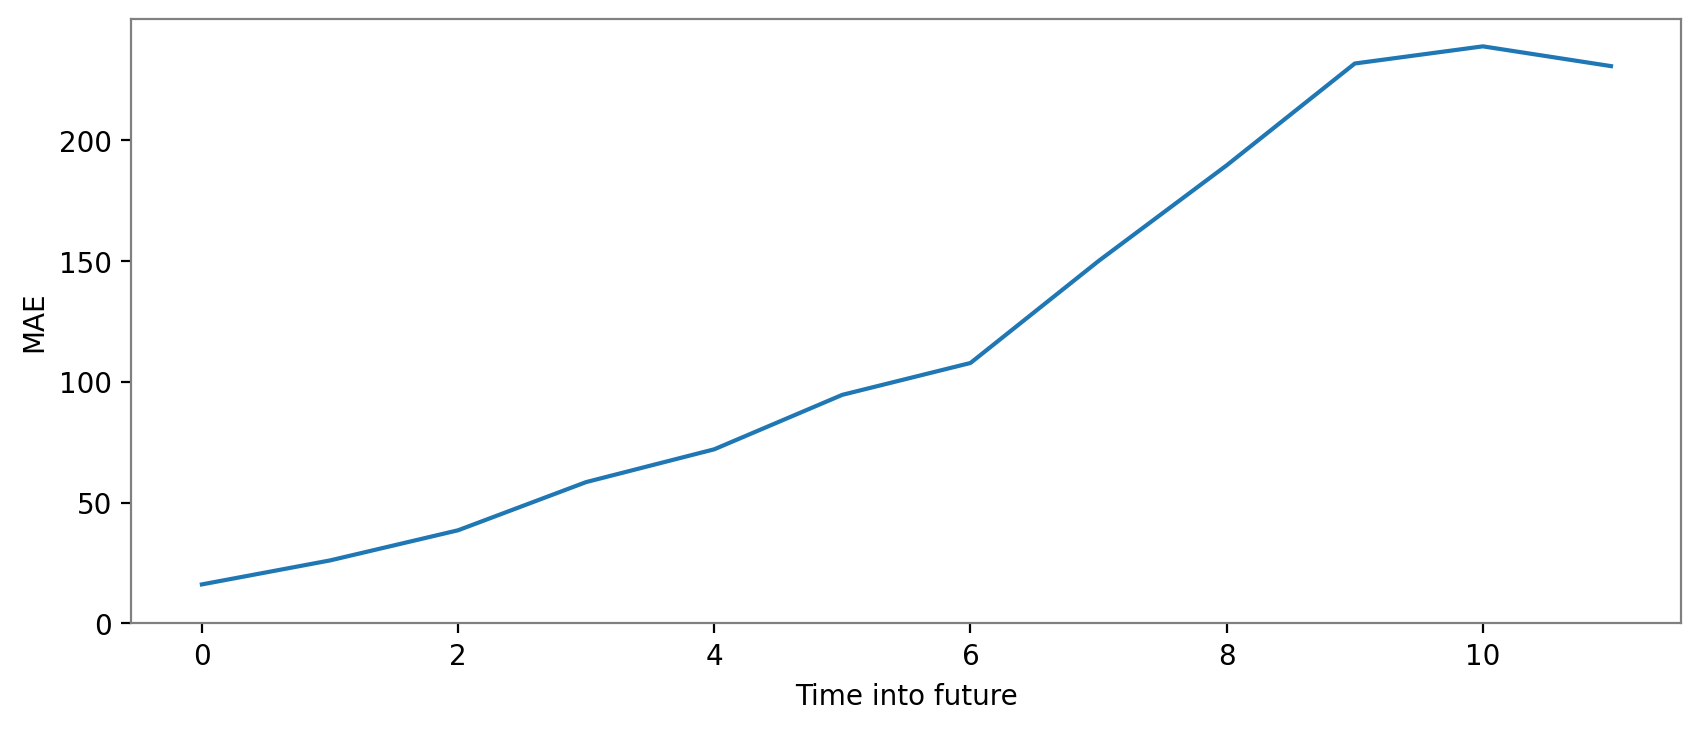

In [17]:
# Plot MAE
plt.plot(fit_eval_d346['mae'])
plt.ylim(0, None)
plt.ylabel("MAE")
plt.xlabel("Time into future");

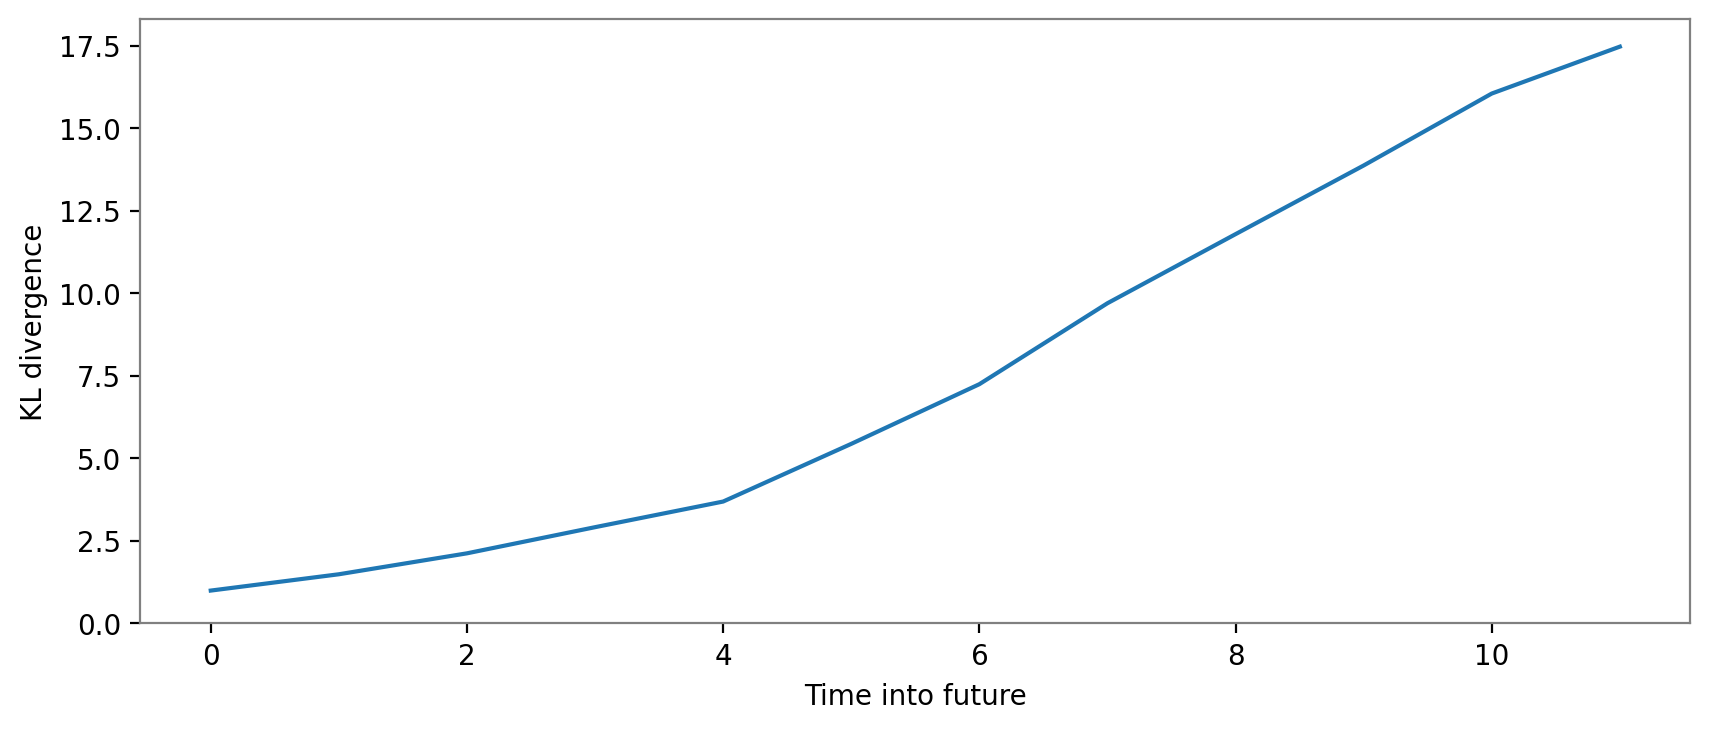

In [18]:
# Plot KL
plt.plot(fit_eval_d346['kl'])
plt.ylim(0, None)
plt.ylabel("KL divergence")
plt.xlabel("Time into future");

In [19]:
# Entropy
if False:
    plt.plot(-fit_eval_d346['log_likelihood'], "r-");
    plt.plot(fit_eval_d346['entropy'], "k--");
    plt.plot(fit_eval_d346['kl'], "g--");

In [20]:
if False:
    plt.plot(fit_eval_d346['log_likelihood'].exp(), "r-");
    plt.plot((-fit_eval_d346['entropy']).exp(), "k--");

# Day 514: B.1.617.2 in UK

Max days of model: 514


    34897 Generating output tensor
    34898 --- Processing query 0


sel_forecast shape torch.Size([49, 1281])
sel_forecast_lb shape torch.Size([49, 1281])


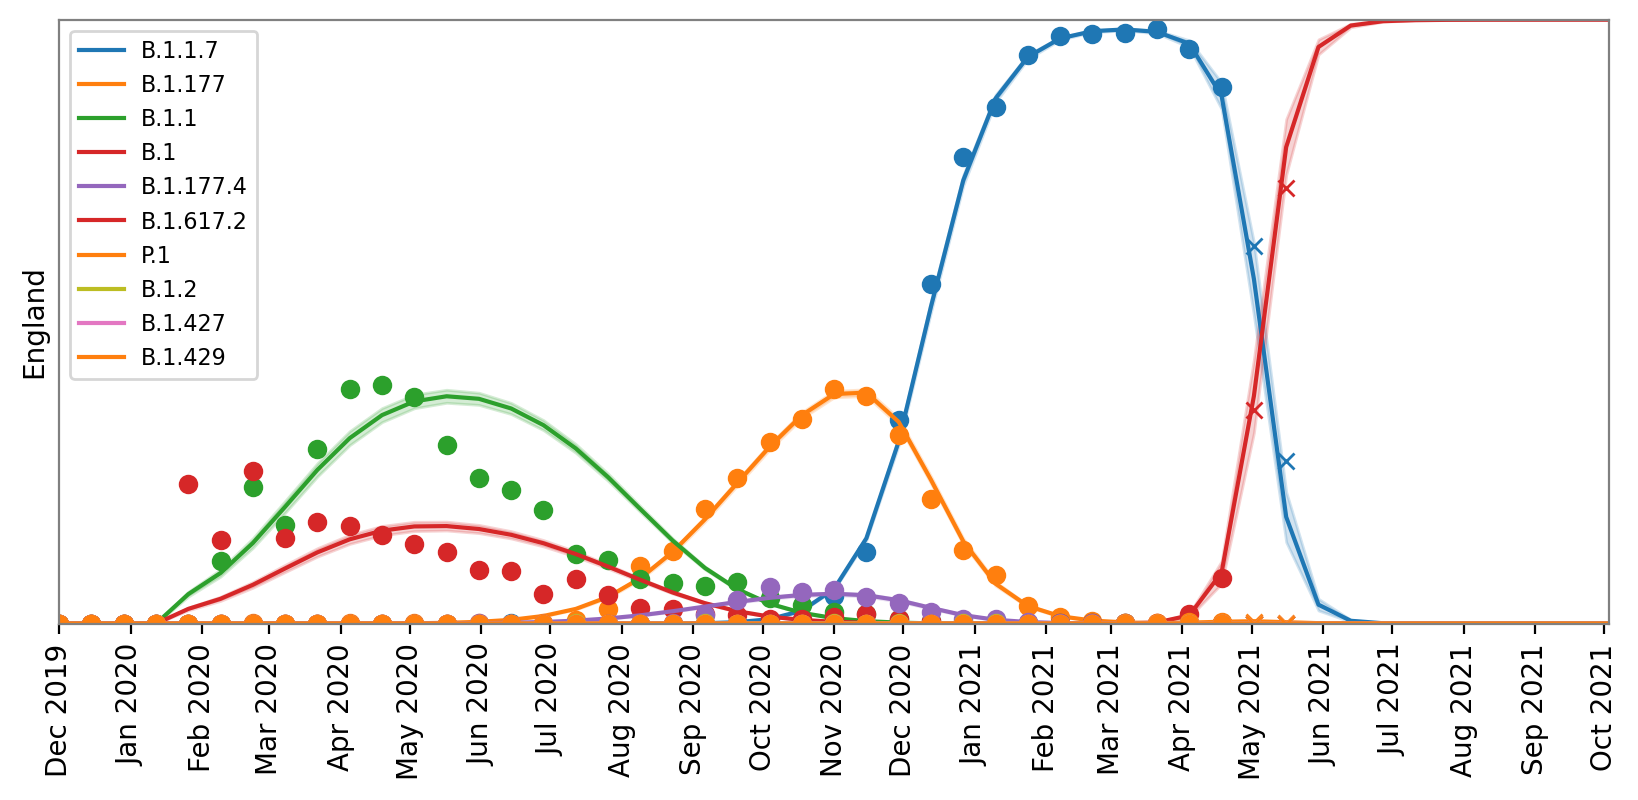

In [21]:
i = 26
key, fit_d514 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d514, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_514.png',
    forecast_periods_plot=2,
)

In [22]:
mutrans_helpers.evaluate_fit_forecast(fit_d514, latest_fit)

{'log_likelihood': tensor([-0.2402, -0.3840]),
 'entropy': tensor([0.6909, 0.6186]),
 'perplexity': tensor([2.2121, 2.0621]),
 'kl': tensor([nan, nan]),
 'mae': tensor([21.0482, 19.3891]),
 'rmse': tensor([0.0000e+00, 7.7132e+01, 1.4247e+00,  ..., 8.9912e-01, 1.2894e-03,
         5.7773e-01]),
 'wasserstein': tensor([148.1149, 191.9854])}

In [23]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [24]:
x = np.linspace(0.0, 1.0, len(evaluations)+1)

In [25]:
cmap = matplotlib.cm.get_cmap('rainbow')

In [26]:
nValues = [k[8] for k,v in evaluations]
nValues = np.array(nValues)

In [27]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet

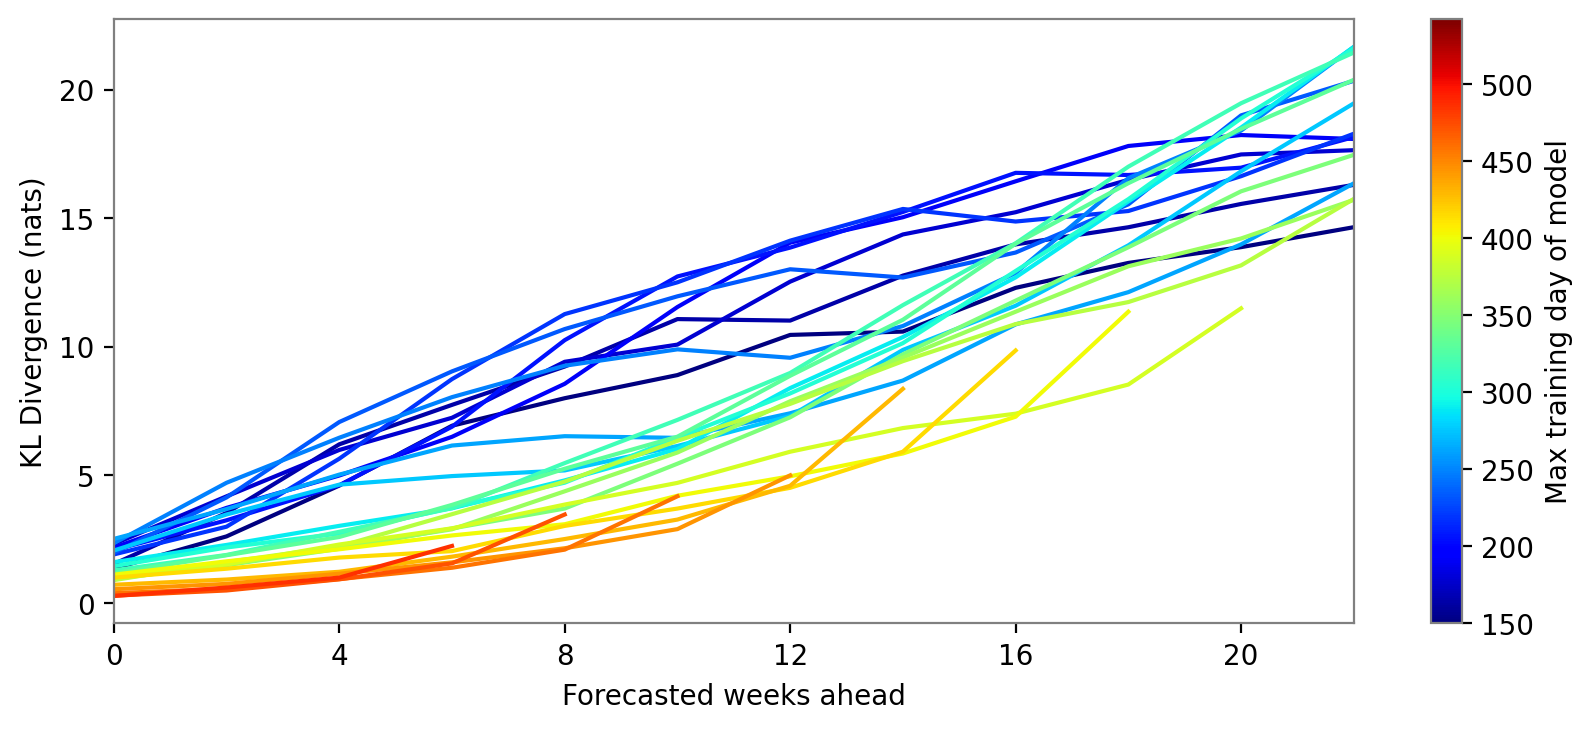

In [28]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    kl = v['kl']
    plt.plot(kl, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('KL Divergence (nats)')

plt.show()

In [29]:
# Alternative representation of KL divergence

start_days = []
forecast_days = []
kl = []

for i,(k,v) in enumerate(evaluations):
    start_days_c = k[8]
    kl_vals = v['kl']
    for j, p in enumerate(kl_vals):
        start_days.append(start_days_c)
        forecast_days.append(j)
        kl.append(p.numpy().item())

df1 = pd.DataFrame({"start":start_days,"forecast":forecast_days,"kl":kl}).pivot(index='start', columns='forecast')

<AxesSubplot:>

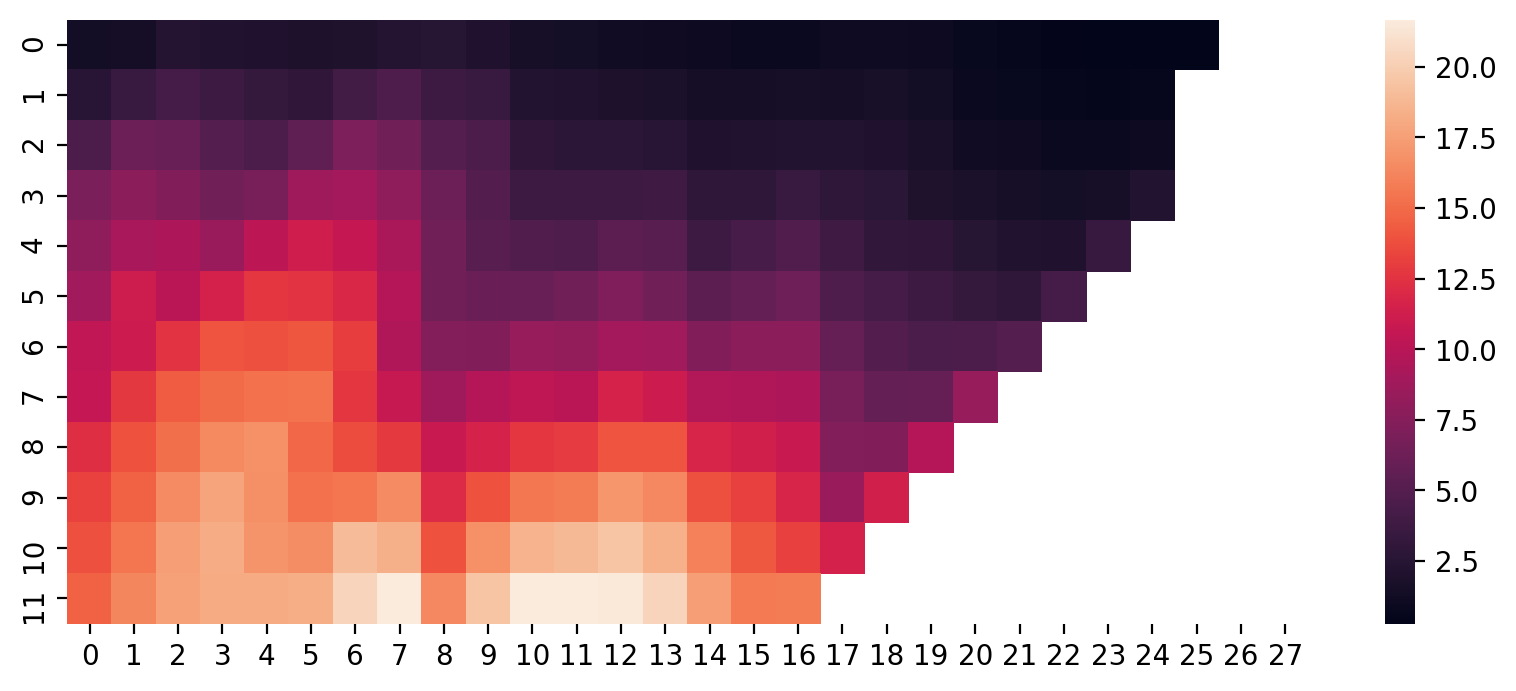

In [30]:
# generate heatmap
sns.heatmap(df1.T.to_numpy())

In [31]:
# MAE

In [32]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

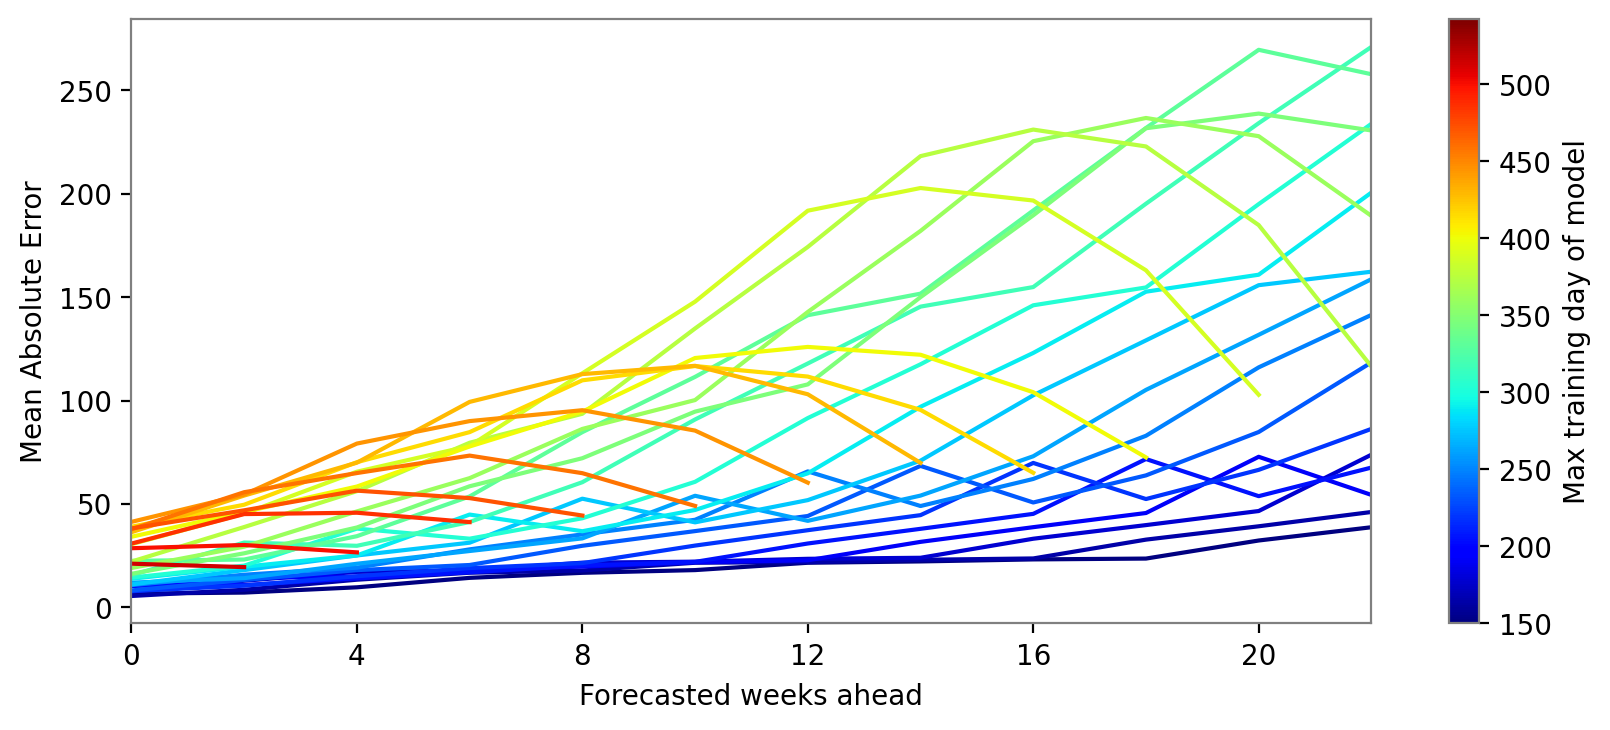

In [33]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['mae']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Mean Absolute Error')

plt.show()

In [34]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

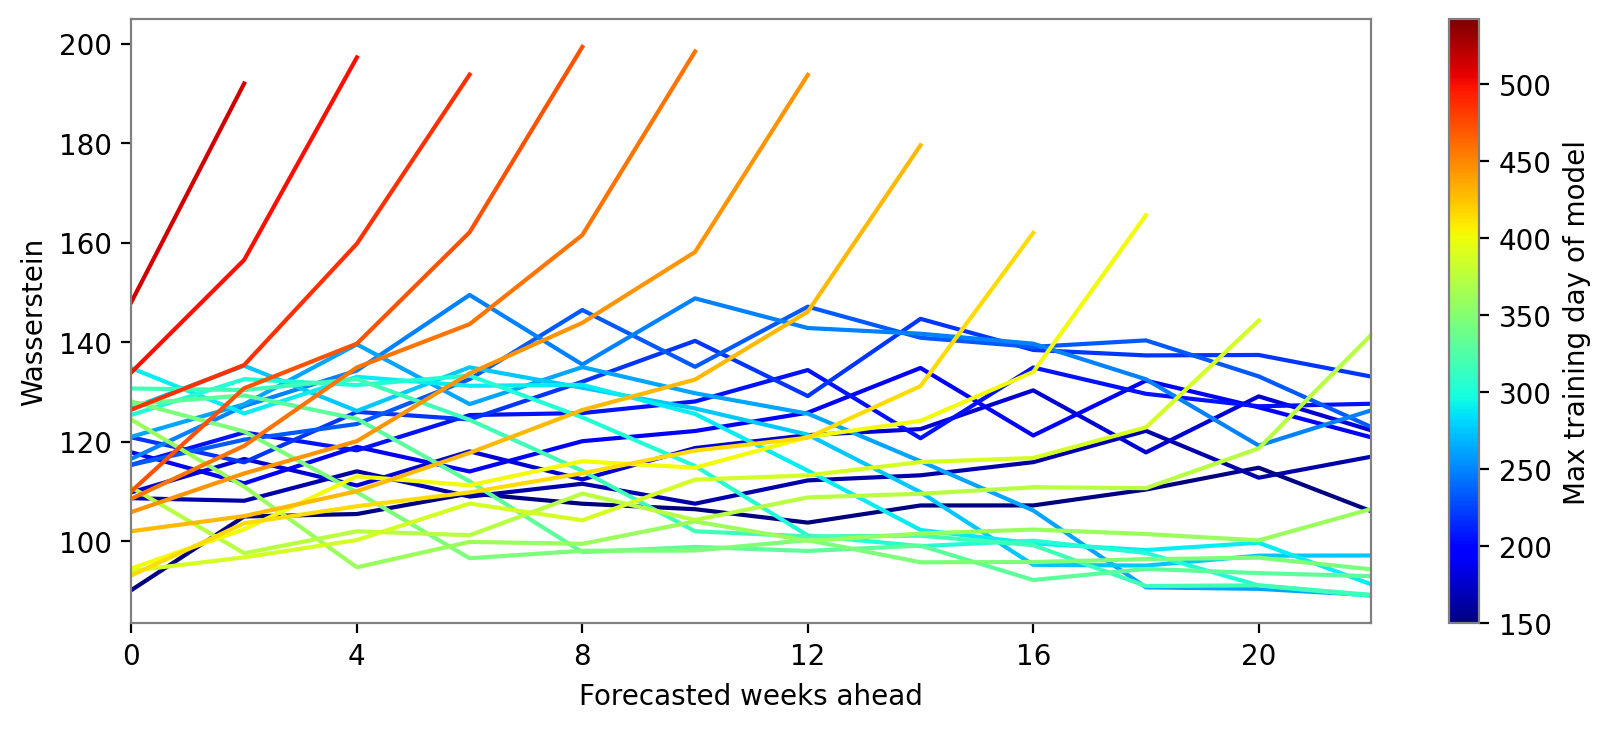

In [35]:
# Wasserstein distance

for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['wasserstein']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Wasserstein')

plt.show()

## Why is USA / California total sum going to zero at the end?

Max days of model: 542


   124780 Generating output tensor
   124781 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


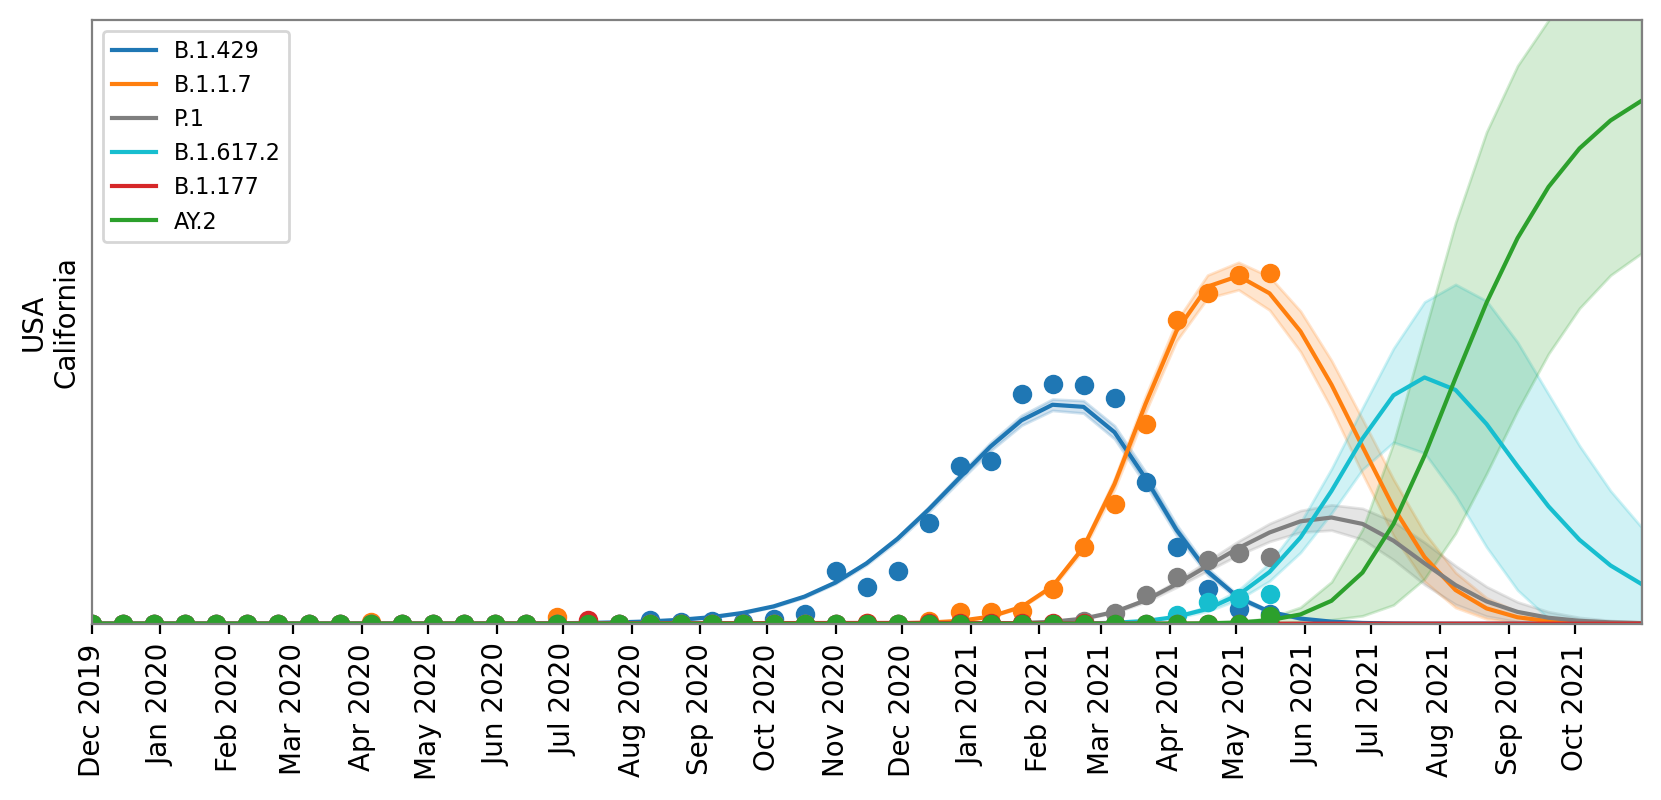

In [36]:
i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['AY.2','B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1']

matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['USA / California'],
)

## CA latest

In [37]:
def get_region_names(fit):
    return fit['location_id']

In [38]:
def find_prevalent_strains(fit, region, n=20):
    """Given a fit and region finds top n strains"""
    assert fit is not None
    assert region is not None
    
    fc0 = mutrans_helpers.generate_forecast(fit)
    
    region_index = fc0['location_id'][region]
    vals, indx = fit['mean']['probs'].max(0)
    so = vals[region_index,].sort(descending=True).indices[0:n].numpy()
    s0 = np.array(fit['lineage_id_inv'])[so].tolist()
    
    return s0
    

In [39]:
def find_prevalent_strains(fit, query, n=20):
    """Given a fit and region finds top n strains"""
    assert fit is not None
    assert region is not None
    
    fc0 = mutrans_helpers.generate_forecast(fit)
    
    
    location_id = fc0['location_id']
    
    
    ids = torch.tensor([i for name, i in location_id.items() if query in name])
    
    #region_index = fc0['location_id'][region]
    
    vals, indx = fit['mean']['probs'].index_select(-2, ids).sum(-2).max(0)
    
    #so = vals[region_index,].sort(descending=True).indices[0:n].numpy()
    so = vals.sort(descending=True).indices[0:n].numpy()
    s0 = np.array(fit['lineage_id_inv'])[so].tolist()
    
    return s0

In [40]:
ca_top_strains = find_prevalent_strains_2(latest_fit, 'North America / USA / California')

NameError: name 'find_prevalent_strains_2' is not defined

In [ ]:
ca_top_strains

## North America / USA / California

In [ ]:
ca_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / California')

In [ ]:
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ca_top_strains,
    queries=['North America / USA / California']
)

## North America / USA / New York

In [ ]:
ny_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / New York')

In [ ]:
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries='North America / USA / New York')

## Europe / United Kingdom / England

In [ ]:
region = 'Europe / United Kingdom / England'
ny_top_strains = find_prevalent_strains(latest_fit, region)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/uk_england.png")

## North America / USA'

In [ ]:
region = 'North America / USA'
ny_top_strains = find_prevalent_strains(latest_fit, region)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/USA.png")

In [ ]:
## North America / USA / Virginia

In [ ]:
region = 'North America / USA / Virginia'
ny_top_strains = find_prevalent_strains(latest_fit, region)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,filename="paper/per_region_forecasts/virginia.png")

In [ ]:
## Europe / Greece / Athens

In [ ]:
region = 'Europe / Greece / Athens'
ny_top_strains = find_prevalent_strains(latest_fit, region)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/europe_athens_greeece.png")

In [ ]:
## North America / USA / Massachusetts

In [ ]:
region = 'North America / USA / Massachusetts'
ny_top_strains = find_prevalent_strains(latest_fit, region)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/massachusetts.png")

## Europe / Germany / Hamburg

In [ ]:
region = 'Europe / Germany / Hamburg'
ny_top_strains = find_prevalent_strains(latest_fit, region)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/europe_germany_hamburg.png")

# Europe / France

In [ ]:
region = 'Europe / France'
top_strains = find_prevalent_strains(latest_fit, region,n=20)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/europe.png")

# USA

In [ ]:
region = 'USA'
top_strains = find_prevalent_strains(latest_fit, region,n=20)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/usa.png")

# Europe

In [ ]:
region = 'Europe'
top_strains = find_prevalent_strains(latest_fit, region,n=20)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
filename="paper/per_region_forecasts/europe.png")

# Asia

In [ ]:
region = 'Asia'
top_strains = find_prevalent_strains(latest_fit, region,n=20)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/asia.png")

# Oceania

In [ ]:
region = 'Oceania'
top_strains = find_prevalent_strains(latest_fit, region,n=20)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/oceania.png")

# Africa

In [ ]:
region = 'Africa'
top_strains = find_prevalent_strains(latest_fit, region,n=20)
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/africa_latest.png")